In [1]:
import os
import random

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

from dataclasses import dataclass

In [61]:
SEED_VALUE = 42
DIR = "."
IMAGE_DIR = os.path.join(DIR, "visuals")
if not os.path.exists(IMAGE_DIR):
    os.makedirs(IMAGE_DIR)

plt.rcParams['figure.facecolor'] = 'beige'

random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

In [3]:
train_set, valid_set, test_set = tfds.load('malaria', split=['train[80%:]', 'train[80%:90%]', 'train[90%:100%]'],
                                           as_supervised=True)
info = tfds.builder("malaria").info

In [5]:
def save_fig(name, fig_extension="png", tight_layout=True, resolution=300):
    path = os.path.join(IMAGE_DIR, name + '.' + fig_extension)
    print(f"Saving figure {name}")
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Saving figure malaria


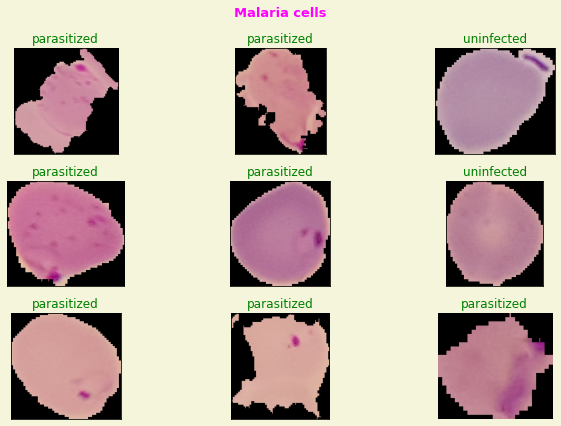

In [49]:
fig = plt.figure(figsize=(10, 6))
for i, (image, label) in enumerate(train_set.take(9)):
  ax = plt.subplot(3, 3, i+1)
  ax.imshow(image)
  ax.set_xticks([]);ax.set_yticks([])
  ax.set_title(f"{info.features['label'].int2str(label)}", color='g')
plt.suptitle("Malaria cells", weight='bold', color='magenta', size=13)
plt.axis('off')
plt.grid(True)
save_fig("malaria")
plt.show()

### Preprocessing.

In [11]:
@dataclass(frozen=True)
class DataConfig():
  IMG_HEIGHT:    int = 32
  IMG_WIDTH:    int = 32
  NUM_CHANNELS: int = 3

@dataclass(frozen=True)
class TrainConfig:
  BATCH_SIZE:    int = 124
  EPOCHS:        int = 35
  LEARNING_RATE: int = 0.001

In [12]:
for image, label in train_set.take(5):
  print(image.shape[0:2])

(232, 229)
(190, 163)
(133, 151)
(139, 154)
(151, 142)


In [13]:
def preprocess_dataset(dataset: tf.data.Dataset, shuffle_dataset=False, augment=False):
  def preprocess_image(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, (DataConfig.IMG_HEIGHT, DataConfig.IMG_WIDTH))
    if augment:
      image = tf.image.random_flip_left_right(image)
      image = tf.image.random_flip_up_down(image)
    # if grayscale:
    #   image = tf.image.rgb_to_grayscale(image)
    #   image = tf.expand_dims(image, axis=1)
    return image, label

  ds = dataset.cache()
  ds = ds.map(preprocess_image)
  ds = ds.batch(TrainConfig.BATCH_SIZE)
  if shuffle_dataset:
    ds = ds.shuffle(buffer_size=5000, reshuffle_each_iteration=True)
  ds = ds.prefetch(tf.data.AUTOTUNE)

  return ds

In [14]:
train_ds = preprocess_dataset(train_set, shuffle_dataset=True, augment=False)
valid_ds = preprocess_dataset(valid_set)
test_ds = preprocess_dataset(valid_set)

Saving figure processed


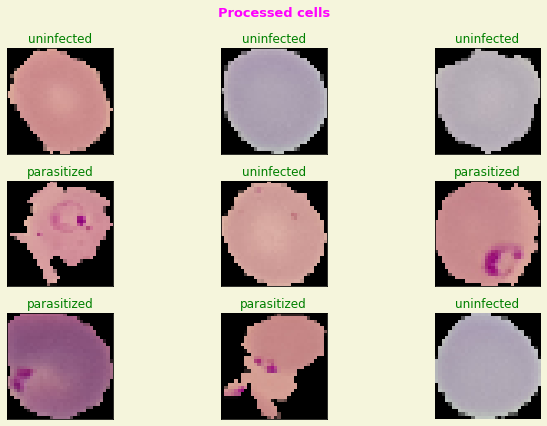

In [50]:
image_batch, label_batch = next(iter(train_ds))
fig = plt.figure(figsize=(10, 6))
for i, (image, label) in enumerate(zip(image_batch, label_batch)):
  if i >= 9:
    break
  ax = plt.subplot(3, 3, i+1)
  ax.imshow(image)
  ax.set_xticks([]);ax.set_yticks([])
  ax.set_title(f"{info.features['label'].int2str(label)}", color='g')
plt.suptitle("Processed cells", weight='bold', color='magenta', size=13)
plt.axis('off')
plt.grid(True)
save_fig("processed")
plt.show()

In [16]:
for image, label in train_ds.take(5):
  print(image.shape[1:3])

(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)


### Model Definition.
- A custom convolutional network inspired by the vgg16.

In [17]:
def custom_cnn(input_shape=(DataConfig.IMG_HEIGHT, DataConfig.IMG_WIDTH, DataConfig.NUM_CHANNELS)):
  model = Sequential()

  model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=input_shape))
  model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
  model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
  model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Flatten())
  model.add(Dense(512, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))

  return model

In [18]:
model = custom_cnn()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 64)          0         
 g2D)                                                   

### Model compiling and training.

In [19]:
model.compile(optimizer=Adam(learning_rate=TrainConfig.LEARNING_RATE),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [20]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [21]:
history = model.fit(train_ds,
                    batch_size=TrainConfig.BATCH_SIZE,
                    epochs=TrainConfig.EPOCHS,
                    validation_data=valid_ds,
                    callbacks=[early_stopping],
                    verbose=1)

Epoch 1/35


45/45 [==============================] - 50s 1s/step - loss: 0.6451 - accuracy: 0.6410 - val_loss: 0.5645 - val_accuracy: 0.7224
Epoch 2/35
45/45 [==============================] - 43s 956ms/step - loss: 0.4119 - accuracy: 0.8135 - val_loss: 0.2883 - val_accuracy: 0.8966
Epoch 3/35
45/45 [==============================] - 39s 863ms/step - loss: 0.1960 - accuracy: 0.9312 - val_loss: 0.1827 - val_accuracy: 0.9394
Epoch 4/35
45/45 [==============================] - 44s 973ms/step - loss: 0.1625 - accuracy: 0.9490 - val_loss: 0.1581 - val_accuracy: 0.9539
Epoch 5/35
45/45 [==============================] - 42s 925ms/step - loss: 0.1459 - accuracy: 0.9548 - val_loss: 0.1337 - val_accuracy: 0.9565
Epoch 6/35
45/45 [==============================] - 51s 1s/step - loss: 0.1325 - accuracy: 0.9570 - val_loss: 0.1238 - val_accuracy: 0.9615
Epoch 7/35
45/45 [==============================] - 44s 961ms/step - loss: 0.1351 - accuracy: 0.9570 - val_loss: 0.1216 - val_accuracy: 0.9623
Epoch 8/35
45/45

In [70]:
def plot_results(metrics, metric_name=None, title=None, ylabel=None, ylim=None, xlim=None, color=None):
  fig, ax = plt.subplots(figsize=(8, 4))
  
  if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
    metrics = [metrics]
    metric_name = [metric_name]

  for idx, metric in enumerate(metrics):
    ax.plot(metric, color=color[idx])

  plt.xlabel("Epochs")
  plt.ylabel(ylabel)
  plt.ylim(ylim)
  plt.xlim(xlim)
  plt.title(title, pad=10.0, weight='bold', color='magenta')

  ax.xaxis.set_major_locator(plt.MultipleLocator(5))
  ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
  ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%d'))
  
  plt.grid(True)
  plt.legend(metric_name)
  save_fig(title)
  plt.show()
  plt.close()

Saving figure Accuracy


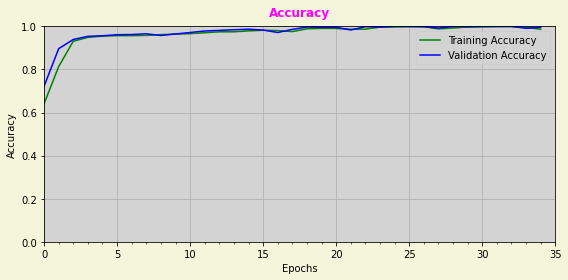

Saving figure Loss


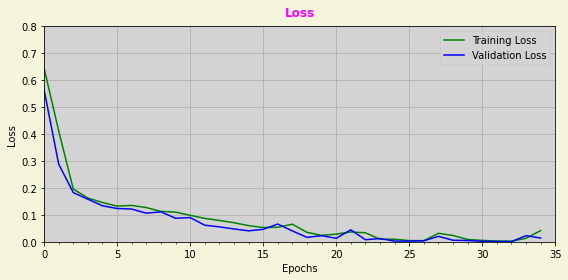

In [71]:
train_acc = history.history["accuracy"]
train_loss = history.history["loss"]
val_acc = history.history["val_accuracy"]
val_loss = history.history["val_loss"]

plot_results([train_acc, val_acc],
             metric_name=['Training Accuracy', 'Validation Accuracy'],
             ylabel="Accuracy", ylim=[0.0, 1.0], xlim=[0, 35],
             title="Accuracy", color=['g', 'b'])

plot_results([train_loss, val_loss],
             metric_name=['Training Loss', 'Validation Loss'],
             ylabel="Loss", ylim=[0.0, 0.8], xlim=[0, 35],
             title="Loss", color=['g', 'b'])

### Adding regularization.

In [ ]:
def custom_cnn_drop(input_shape=(DataConfig.IMG_HEIGHT, DataConfig.IMG_WIDTH, DataConfig.NUM_CHANNELS)):
  model = Sequential()

  model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=input_shape))
  model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
  model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
  model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(1, activation='sigmoid'))

  return model

In [ ]:
drop_model = custom_cnn_drop()
drop_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 conv2d_19 (Conv2D)          (None, 224, 224, 32)      9248      
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 112, 112, 32)      0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 112, 112, 32)      0         
                                                                 
 conv2d_20 (Conv2D)          (None, 112, 112, 64)      18496     
                                                                 
 conv2d_21 (Conv2D)          (None, 112, 112, 64)      36928     
                                                      

In [ ]:
drop_model.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

In [ ]:
drop_history = drop_model.fit(train_ds,
                              batch_size=TrainConfig.BATCH_SIZE,
                              epochs=TrainConfig.EPOCHS,
                              validation_data=valid_ds,
                              verbose=1)

Epoch 1/50
22/22 [==============================] - 110s 1s/step - loss: 0.9462 - accuracy: 0.4935 - val_loss: 0.6932 - val_accuracy: 0.4888
Epoch 2/50
22/22 [==============================] - 31s 1s/step - loss: 0.6931 - accuracy: 0.5105 - val_loss: 0.6929 - val_accuracy: 0.5842
Epoch 3/50
22/22 [==============================] - 30s 1s/step - loss: 0.6914 - accuracy: 0.5396 - val_loss: 0.6900 - val_accuracy: 0.6132
Epoch 4/50
22/22 [==============================] - 30s 1s/step - loss: 0.6810 - accuracy: 0.5795 - val_loss: 0.6684 - val_accuracy: 0.6063
Epoch 5/50
22/22 [==============================] - 30s 1s/step - loss: 0.6622 - accuracy: 0.6058 - val_loss: 0.6577 - val_accuracy: 0.6205
Epoch 6/50
22/22 [==============================] - 30s 1s/step - loss: 0.6438 - accuracy: 0.6286 - val_loss: 0.6224 - val_accuracy: 0.6513
Epoch 7/50
22/22 [==============================] - 31s 1s/step - loss: 0.6280 - accuracy: 0.6439 - val_loss: 0.6092 - val_accuracy: 0.6604
Epoch 8/50
22/22 [=

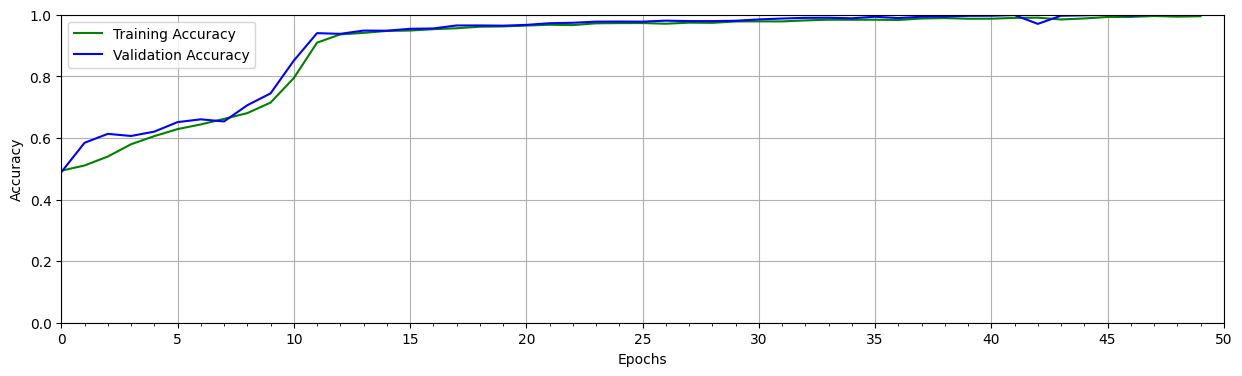

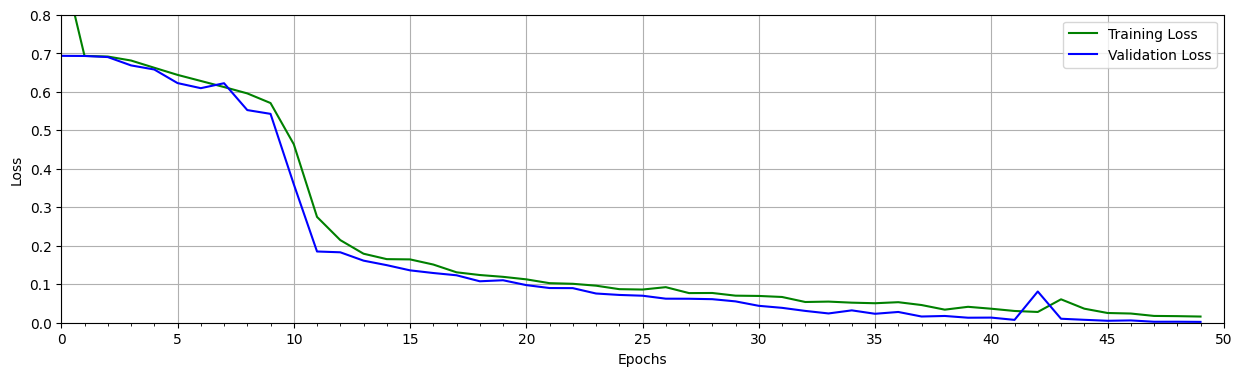

In [ ]:
train_acc = drop_history.history["accuracy"]
train_loss = drop_history.history["loss"]
val_acc = drop_history.history["val_accuracy"]
val_loss = drop_history.history["val_loss"]

plot_results([train_acc, val_acc],
             metric_name=['Training Accuracy', 'Validation Accuracy'],
             ylabel="Accuracy", ylim=[0.0, 1.0],
             color=['g', 'b'])

plot_results([train_loss, val_loss],
             metric_name=['Training Loss', 'Validation Loss'],
             ylabel="Loss", ylim=[0.0, 0.8],
             color=['g', 'b'])

### Model Evaluation.

In [72]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc * 100:.3f}")

23/23 [==============================] - 28s 820ms/step - loss: 0.0140 - accuracy: 0.9956
Test accuracy: 99.565


In [73]:
def evaluate_model(dataset: tf.data.Dataset, model, rows: int=3, cols: int=5):
  class_names = ['parasitized', 'uninfected']

  image_batch, label_batch = next(iter(dataset.take(1)))

  predictions = model.predict(image_batch)

  plt.figure(figsize=(15, 10))
  matches = 0

  for idx in range(min(len(image_batch), rows * cols)):
    ax = plt.subplot(rows, cols, idx+1)
    plt.axis('off')
    plt.imshow(image_batch[idx])

    pred_idx = predictions[idx] if predictions[idx].shape == () else tf.argmax(predictions[idx]).numpy()
    truth_idx = label_batch[idx] if label_batch[idx].shape == () else tf.argmax(label_batch[idx]).numpy()

    title = str(class_names[truth_idx]) + ":" + str(class_names[pred_idx])
    title_obj = plt.title(title, fontdict={'fontsize': 14})
    if pred_idx == truth_idx:
      matches += 1
      plt.setp(title_obj, color='g')
    else:
      plt.setp(title_obj, color='r')

    acc = matches / (idx+1)
  print(f"Prediction accuracy: {int(acc * 100)/100}")

  return

4/4 [==============================] - 2s 122ms/step
Prediction accuracy: 0.73


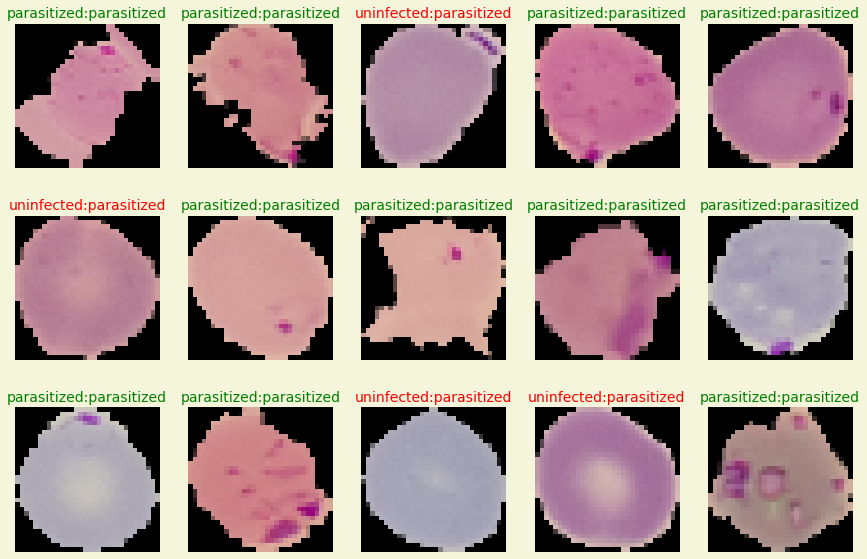

In [75]:
evaluate_model(test_ds, model)

### Confusion matrix.

In [76]:
predictions = model.predict(test_ds)
predicted_labels = [tf.argmax(i) for i in predictions]

23/23 [==============================] - 8s 330ms/step


In [ ]:
model